The following notebook explores the use of an LSTM Model. The LSTM model has historically been known to perform well on sequential data which directly influenced its success in the field of NLP. We grid search over a series of parameters by carrying out 5 fold cross validation. After which we present a confusion matrix and various evaluation metrics along with their mean and standard deviation to assess the performance of the model.


# Data Preprocessing

## Importing Libraries

In [ ]:
import sys
import time
import os
import math
import copy
import string
import re
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset, TensorDataset
from torch.autograd import Variable

import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# utilising the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
%%shell
curl -fsS https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip -o /tmp/trainDevTestTrees_PTB.zip
unzip -q -o -d /tmp /tmp/trainDevTestTrees_PTB.zip
rm -f /tmp/trainDevTestTrees_PTB.zip

In [ ]:
# https://stackoverflow.com/questions/55444572/how-does-i-unzip-pretrained-word2vec-in-google-colab
start_time = time.time()
!wget -P /tmp/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
elapsed_time = time.time() - start_time
print('Downloading the pre-trained Word2Vec model took %d seconds' %(elapsed_time))

--2020-06-30 17:54:09--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.95.13
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.95.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/tmp/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  21.2MB/s    in 41s     

2020-06-30 17:54:50 (38.8 MB/s) - ‘/tmp/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
# Load Google's pre-trained Word2Vec model.
start_time = time.time()
word2Vec_filePath = '/tmp/GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(word2Vec_filePath, binary=True)
!rm -f word2Vec_filePath
elapsed_time = time.time() - start_time
print('Loading the pre-trained Word2Vec model took %d seconds' %(elapsed_time))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Loading the pre-trained Word2Vec model took 127 seconds


## Cleaning the Sentences

Split data into sentences and labels

In [ ]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
filepath = "gdrive/My Drive/ted_training_pairs_NLTK2.csv"

data = pd.read_csv(filepath)

sentences = data['text'].values
labels = data['label'].values

In [ ]:
labels[0]

'laughter'

Remove punctuation from each sentence

In [ ]:
#Create list of all punctuation in the text
punctuation = []
for p in string.punctuation:
    punctuation.append(p)
punctuation.append("''")
punctuation.append("--")
punctuation.append("##")
punctuation.append("``")

In [ ]:
#Removing punctuation
new_sentences = []
for sentence in sentences:
    words = sentence.split()
    no_punc_words = [words[i] for i in range(len(words)) if words[i] not in punctuation]
    new_sentences.append(" ".join(no_punc_words))

Creat a dictionary of the vocabulary in order of most frequent words

In [ ]:
from collections import Counter

all_text = ' '.join(new_sentences)
words = all_text.split()

# Count all the words using Counter Method
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [ ]:
vocab_to_int = {w:i for i,(w,c) in enumerate(sorted_words)}
int_to_vocab = {i:w for i,(w,c) in enumerate(sorted_words)}

vocab_size = len(vocab_to_int)

As we are now using pretrained embeddings I will include an 'UNK' term to consider all elements that we have not included in our text corpus

In [ ]:
vocab_to_int['UNK'] = vocab_size +1
int_to_vocab[vocab_size + 1] = 'UNK'

vocab_size  = len(vocab_to_int) + 1

In [ ]:
vocab_size

22943

Now we will build our pretrained weight matrix

In [ ]:
# create array of train embeddings vectors to be fed into torch
emb_weights =  np.zeros((vocab_size, 300))

for key, val in int_to_vocab.items():
    if val in model.vocab:
        emb = model.get_vector(val)
        emb_weights[key] = emb

# creating torch embedding objects of training data embedding array
# - this is in the same order as we have in our dictionary
emb_weights = torch.FloatTensor(emb_weights)   

In [ ]:
#Delete the full Word2Vec model to free up disk space
del model

In [ ]:
emb_weights.shape

torch.Size([22943, 300])

We will now tokenize the sentences using the dictionaries above

In [ ]:
sentence_tokens = []
for sentence in new_sentences:
    r = [vocab_to_int[w] for w in sentence.split()]
    sentence_tokens.append(r)

Now we will tokenize the labels

In [ ]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
labels_enc = enc.fit_transform(labels)

In [ ]:
labels_enc[0]

0

We will now visualise the length of the sentences in order to set the number of steps in the LSTM

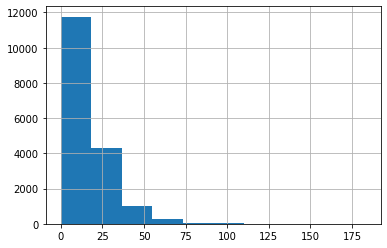

count    17466.000000
mean        16.545918
std         13.937757
min          0.000000
25%          7.000000
50%         13.000000
75%         22.000000
max        183.000000
dtype: float64

In [ ]:
sentence_len = [len(x) for x in sentence_tokens]
pd.Series(sentence_len).hist()
plt.show()
pd.Series(sentence_len).describe()

Now in order to define the LSTM model we will set a Sequence Length and pad all sentences that are shorter than the sequence length as well as truncate all sentences that are longer than the sequence length. This Sequence Length is chosen by observing the distribution of sentence lengths as seen above and choosing a length that approaches the "elbow" of the distribution.

In [ ]:
def padded_tokens(sentences, seq_len):
    #If sentence length is shorter than the seq_len we will pad the sentence with 0 and if the sentence is longer than the seq_len we will truncate the sentence
    padded_features = np.zeros((len(sentence_tokens), seq_len), dtype = int)
    for i, sentence in enumerate(sentences):
        if len(sentence) <= seq_len:
            padding = list(np.zeros(seq_len - len(sentence)))
            new = padding + sentence
        else:
            new = sentence[:seq_len]
        padded_features[i, :] = new
        
    return padded_features

In [ ]:
padded_sent_tokens = padded_tokens(sentence_tokens, 30)

## Creating Tensor Datasets and DataLoaders

We will now split the dataset as necessary

In [ ]:
indices = list(range(len(padded_sent_tokens)))

In [ ]:
from sklearn.model_selection import train_test_split

train_indices, remaining_indices = train_test_split(indices, test_size = 0.2, shuffle = True)
test_indices, val_indices = train_test_split(remaining_indices, test_size = 0.5, shuffle = True)

X_train = padded_sent_tokens[train_indices]
y_train = labels_enc[train_indices]

X_val = padded_sent_tokens[val_indices]
y_val = labels_enc[val_indices]

X_test = padded_sent_tokens[test_indices]
y_test = labels_enc[test_indices]

We will now format our data into batchs using the DataLoader

In [ ]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
# dataloaders
batch_size = 50
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last = True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last = True)

In [ ]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 30])
Sample input: 
 tensor([[    0,     0,     0,  ...,   107,    23,  1007],
        [    0,     0,     0,  ...,  2101,    66,   365],
        [    0,     0,     0,  ...,     5,    34,    13],
        ...,
        [10139, 18556,  6559,  ...,   226,   689,   249],
        [    0,     0,     0,  ...,     0,   235,   984],
        [    0,     0,     0,  ...,   905,    35,   120]])

Sample label size:  torch.Size([50])
Sample label: 
 tensor([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        1, 1])


# Training

We will now design the LSTM model

In [ ]:
class SentimentLSTM(nn.Module):
    
    def __init__(self, vocab_size, output_size, hidden_dim, n_layers, batch_size, drop_prob=0.5):

        super().__init__()

        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.batch_size = batch_size

        #We first feed the sentences to an embedding layer
        self.embedding = nn.Embedding.from_pretrained(emb_weights)

        #We then feed the embedding vectors to the LSTM
        self.lstm = nn.LSTM(300, hidden_dim, n_layers, dropout = drop_prob, batch_first = True)

        #Implement a dropout layer before feeding the input to the dense layers
        self.dropout = nn.Dropout(0.3)

        #Implement Linear layer, we do not have to implement a sigmoid layer as CrossEntropy loss will apply softmax
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x, hidden):

        embeddings = self.embedding(x)
        lstm_out, hidden = self.lstm(embeddings, hidden)

        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(self.batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # return last sigmoid output and hidden state
        return sig_out, hidden

    def init_hidden(self, batch_size):

        weight = next(self.parameters()).data

        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
              weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))

        return hidden

## Helper Functions

Function to train the model

In [ ]:
def train(iterator, Model, optimizer, criterion, batch_size):
    
    Model.train()
    #Initialise the hidden dimension
    h = Model.init_hidden(batch_size)
    clip = 5
    
    # Train the model
    train_loss = 0
    train_acc = 0
    labs = np.array([])

    preds = np.array([])
    pred_scores = np.array([])

    for text, labels in iterator:
        text, labels = text.to(device), labels.to(device)
        
        h = tuple([each.data for each in h]) #Creating new variables for the hidden state, otherwise we'd backprop through the entire training history
        
        #Zero the accumulated gradients
        Model.zero_grad()
        
        #Get the ouput
        inputs = text.type(torch.LongTensor).to(device)
        output, h = Model(inputs, h)
        pred_scores = np.append(pred_scores, output.detach().cpu())
        labs = np.append(labs, labels.detach().cpu())
        #Calculate loss and backpropogate gradients
    
        loss = criterion(output.squeeze(), labels.float())
        train_loss +=loss.item()
        loss.backward()
        #Clip gradients to avoid exploding/vanishing gradients
        nn.utils.clip_grad_norm_(Model.parameters(), clip)
        optimizer.step()
        rounded_preds = torch.round(output)
        preds = np.append(preds, rounded_preds.detach().cpu())
        
        acc = (rounded_preds == labels).float().sum().item()
        train_acc += acc

    targets = iterator.dataset.tensors[1]
    lim = len(targets) % batch_size
    f1 =  f1_score(labs,  preds)
    auc = roc_auc_score(labs, pred_scores)

    return train_loss/len(iterator) , train_acc / len(iterator.dataset), f1, auc

def evaluate(iterator, Model, criterion, batch_size):

    Model.eval()
    
    h = Model.init_hidden(batch_size)
    
    test_loss = 0
    test_acc = 0
    labs = np.array([])

    preds = np.array([])
    pred_scores = np.array([])
    
    for text, labels in iterator:
        text, labels = text.to(device), labels.to(device)
        h = tuple([each.data for each in h])
        with torch.no_grad():
            inputs = text.type(torch.LongTensor).to(device)
            output, h = Model(inputs, h)
            pred_scores = np.append(pred_scores, output.detach().cpu())
            loss = criterion(output.squeeze(), labels.float())
            test_loss += loss.item()
            rounded_preds = torch.round(output)
            preds = np.append(preds, rounded_preds.detach().cpu())
            labs = np.append(labs, labels.detach().cpu())
            acc = (rounded_preds == labels).float().sum().item()
            test_acc += acc

    targets = iterator.dataset.tensors[1]
    lim = len(targets) % batch_size
    f1 =  f1_score(labs,  preds)
    auc = roc_auc_score(labs, pred_scores)

    return test_loss /len(iterator) , test_acc / len(iterator.dataset), f1, auc, preds


In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Helper function to make plots of the loss and accuracy on the training set and validation set

In [ ]:
def plot_loss_accuracy(train_loss, valid_loss, train_acc, valid_acc):
    #plots the loss and accuracy of training and validation set during training
    # comment out to suppress plot output
    fig = plt.figure(figsize=plt.figaspect(0.2))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(train_loss, 'b')
    ax1.plot(valid_loss, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    ax1.legend(['Train', 'Validation'])  
    
    ax1 = fig.add_subplot(1,2,2)
    ax1.plot(train_acc, 'b')
    ax1.plot(valid_acc, 'r')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'])

    ltrain = np.array(train_loss)  
    least_train_epoch = np.argmin(ltrain)
    least_train_loss = min(train_loss)
    print('Lowest training loss:',least_train_loss,'achieved at epoch:',least_train_epoch)
    
    lval = np.array(valid_loss)  
    least_val_epoch = np.argmin(lval)
    least_val_loss = min(valid_loss)
    print('Lowest validation loss:',least_val_loss,'achieved at epoch:',least_val_epoch)
    
    atrain = np.array(train_acc)  
    best_train_epoch = np.argmax(atrain)
    best_train_accuracy = max(train_acc)
    print('Best training accuracy:',best_train_accuracy * 100,'achieved at epoch:',best_train_epoch)
    aval = np.array(valid_acc)  
    best_val_epoch = np.argmax(aval)
    best_val_accuracy = max(valid_acc)
    print('Best validation accuracy:',best_val_accuracy*100,'achieved at epoch:',best_val_epoch,'\n')
    
    return least_train_loss, least_val_loss, best_train_accuracy, best_val_accuracy

In [ ]:
vocab_size = len(vocab_to_int) + 1
batch_size = 50
output_size = 1
hidden_dim = 128
n_layers = 2

LSTM_model = SentimentLSTM(vocab_size, output_size, hidden_dim, n_layers, batch_size).to(device)

print(LSTM_model)

SentimentLSTM(
  (embedding): Embedding(22943, 300)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training Loop

Define the model criterion and optimizer

In [ ]:
# loss function - using cross entropy loss
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(LSTM_model.parameters(), lr=0.0001)

Epoch: 1  | time in 0 minutes, 5 seconds
	 Train: 	Loss: 0.691897	|	Acc: 52.476%(train)
	 Validation: 	Loss: 0.688412	|	Acc: 51.975%(valid) 

Epoch: 2  | time in 0 minutes, 11 seconds
	 Train: 	Loss: 0.674866	|	Acc: 58.016%(train)
	 Validation: 	Loss: 0.660919	|	Acc: 59.244%(valid) 

Epoch: 3  | time in 0 minutes, 16 seconds
	 Train: 	Loss: 0.664039	|	Acc: 59.090%(train)
	 Validation: 	Loss: 0.658668	|	Acc: 57.413%(valid) 

Epoch: 4  | time in 0 minutes, 21 seconds
	 Train: 	Loss: 0.658954	|	Acc: 60.013%(train)
	 Validation: 	Loss: 0.655663	|	Acc: 59.702%(valid) 

Epoch: 5  | time in 0 minutes, 26 seconds
	 Train: 	Loss: 0.654421	|	Acc: 60.915%(train)
	 Validation: 	Loss: 0.656433	|	Acc: 58.157%(valid) 

Epoch: 6  | time in 0 minutes, 32 seconds
	 Train: 	Loss: 0.649801	|	Acc: 61.086%(train)
	 Validation: 	Loss: 0.653237	|	Acc: 59.531%(valid) 

Epoch: 7  | time in 0 minutes, 37 seconds
	 Train: 	Loss: 0.646434	|	Acc: 61.759%(train)
	 Validation: 	Loss: 0.654676	|	Acc: 59.531%(valid) 



(0.6366226873944737,
 0.6525618714444777,
 0.6276839393071858,
 0.6016027475672582)

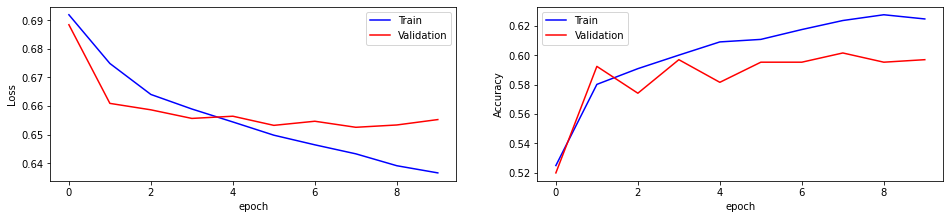

In [ ]:
max_epochs = 10

train_losses = []
train_accs = []

val_losses = []
val_accs = []

least_val_loss = float('inf')
best_val_acc = 0

start_time = time.time()
for epoch in range(max_epochs):
    
    train_loss, train_acc, _, _ = train(train_loader, LSTM_model, optimizer, criterion, batch_size)
    val_loss, val_acc, _, _, _ = evaluate(valid_loader, LSTM_model, criterion, batch_size)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if val_loss < least_val_loss:
        least_val_loss = val_loss
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        
    secs = int(time.time() - start_time)
    mins = secs / 60
    secs = secs % 60
    
    print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
    print(f'\t Train: \tLoss: {train_loss:.6f}\t|\tAcc: {train_acc * 100:.3f}%(train)')
    print(f'\t Validation: \tLoss: {val_loss:.6f}\t|\tAcc: {val_acc * 100:.3f}%(valid)','\n')
    
        
secs = int(time.time() - start_time)
mins = secs / 60
secs = secs % 60
print("Training time : %d minutes, %d seconds" %(mins, secs))
plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs)

# Grid Search

In [ ]:
N_EPOCHS = 30

vocab_size = len(vocab_to_int) + 1
output_size = 1
hidden_dims = [64, 128, 256]
n_layers = 2

learning_rates = [0.00005, 0.0001, 0.001]
batch_sizes = [64, 128, 256]

best_valid_loss = float('inf')

# Here is where we implement the CV

skf1 = StratifiedKFold(5)

# averages over the test set
test_loss_avg = []
test_acc_avg = []
test_auc_avg = []
test_f1_avg = []

train_loss_avg = []
train_acc_avg = []
train_auc_avg = []
train_f1_avg = []

conf_matrices = []

for train_indices_m, test_indices in skf1.split(indices, labels_enc):
  # create test set

  skf2 = StratifiedKFold(5)
  # averages over train and validation splits
  train_losses_avg = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  train_accs_avg = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  train_aucs_avg = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  train_f1s_avg = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))

  train_losses_std = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  train_accs_std = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  train_aucs_std = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  train_f1s_std = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))

  val_losses_avg = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  val_accs_avg = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  val_aucs_avg = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  val_f1s_avg = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))

  val_losses_std = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  val_accs_std = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  val_aucs_std = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))
  val_f1s_std = np.zeros((len(batch_sizes), len(learning_rates), len(hidden_dims)))

  count = 0
  # iterate over params
  for i,batch_size in enumerate(batch_sizes):

    for j,lr in enumerate(learning_rates):

        for k, hidden_dim in enumerate(hidden_dims):

            print("Currently Running Combinations:", (count + 1), "/", (len(batch_sizes) * len(learning_rates) * len(hidden_dims)))
            count += 1

            # losses will be averaged
            train_losses = []
            train_accs = []
            train_f1s = []
            train_aucs = []

            val_losses = []
            val_accs = []
            val_f1s = []
            val_aucs = []

            # CV for each parameter combination
            for train_indices,val_indices in skf2.split(train_indices_m , labels_enc[train_indices_m]):


                # now split train and test
                X_train = padded_sent_tokens[train_indices]
                y_train = labels_enc[train_indices]

                X_val = padded_sent_tokens[val_indices]
                y_val = labels_enc[val_indices]

                # create Tensor datasets as usual
                train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
                valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
                
                # dataloaders
                # make sure to SHUFFLE your data
                train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last = True)
                valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last = True)

                model = SentimentLSTM(vocab_size, output_size, hidden_dim, n_layers, batch_size).to(device)

                # loss function - using cross entropy loss
                criterion = nn.BCELoss().to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr = lr)

                e_train_loss = np.inf
                e_train_acc = 0
                e_train_f1 = 0
                e_train_auc = 0
                
                e_valid_loss = np.inf
                e_valid_acc = 0
                e_valid_f1 = 0
                e_valid_auc = 0

                for epoch in range(N_EPOCHS):

                  start_time = time.time()
                  
                  train_loss, train_acc, train_f1, train_auc = train(train_loader, model, optimizer, criterion, batch_size)
                  valid_loss, valid_acc, valid_f1, valid_auc, _ = evaluate(valid_loader, model, criterion, batch_size)
                  
                  if valid_acc > e_valid_acc:
                      e_train_loss = train_loss
                      e_train_acc = train_acc
                      e_train_f1 = train_f1
                      e_train_auc = train_auc
                      
                      e_valid_loss = valid_loss
                      e_valid_acc = valid_acc
                      e_valid_f1 = valid_f1
                      e_valid_auc = valid_auc
                  
                  
                  end_time = time.time()

                  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
                  
                  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
                  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

                clear_output(True)

                train_losses.append(e_train_loss)
                train_accs.append(e_train_acc)
                train_f1s.append(e_train_f1)
                train_aucs.append(e_train_auc)
                
                val_losses.append(e_valid_loss)
                val_accs.append(e_valid_acc)
                val_f1s.append(e_valid_f1)
                val_aucs.append(e_valid_auc)

            train_losses_avg[i, j, k] = np.array(train_losses).mean()
            train_accs_avg[i, j, k] = np.array(train_accs).mean()
            train_aucs_avg[i, j, k] = np.array(train_aucs).mean()
            train_f1s_avg[i, j, k] = np.array(train_f1s).mean()

            train_losses_std[i, j, k] = np.array(train_losses).std()
            train_accs_std[i, j, k] = np.array(train_accs).std()
            train_aucs_std[i, j, k] = np.array(train_aucs).std()
            train_f1s_std[i, j, k] = np.array(train_f1s).std()

            val_losses_avg[i, j, k] = np.array(train_losses).mean()
            val_accs_avg[i, j, k] = np.array(train_accs).mean()
            val_aucs_avg[i, j, k] = np.array(train_aucs).mean()
            val_f1s_avg[i, j, k] = np.array(train_f1s).mean()

            val_losses_std[i, j, k] = np.array(train_losses).std()
            val_accs_std[i, j, k] = np.array(train_accs).std()
            val_aucs_std[i, j, k] = np.array(train_aucs).std()
            val_f1s_std[i, j, k] = np.array(train_f1s).std()


  print("The Grid Search is complete and the Model has been set to the best parameters found")
  i, j, k = np.unravel_index(np.argmin(val_losses_avg),val_losses_avg.shape)
  best_batch_size = batch_sizes[i]
  best_lr = learning_rates[j]
  best_hidden_dim = hidden_dims[k]

  model = SentimentLSTM(vocab_size, output_size, best_hidden_dim, n_layers, best_batch_size).to(device)

  # loss function - using cross entropy loss
  criterion = nn.BCELoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr = best_lr)

  train_indices, valid_indices = train_test_split(train_indices_m, test_size = 0.2, shuffle = True) 

  X_train = padded_sent_tokens[train_indices]
  y_train = labels_enc[train_indices]

  X_val = padded_sent_tokens[valid_indices]
  y_val = labels_enc[valid_indices]

  X_test = padded_sent_tokens[test_indices]
  y_test = labels_enc[test_indices]

  train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
  valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
  test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

  train_loader = DataLoader(train_data, shuffle=True, batch_size = best_batch_size, drop_last = True)
  valid_loader = DataLoader(valid_data, shuffle=True, batch_size = best_batch_size, drop_last = True)
  test_loader = DataLoader(test_data, shuffle=True, batch_size = best_batch_size, drop_last = True)

  e_train_loss = np.inf
  e_train_acc = 0
  e_train_f1 = 0
  e_train_auc = 0
  
  e_valid_loss = np.inf
  e_valid_acc = 0
  e_valid_f1 = 0
  e_valid_auc = 0

  for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_f1, train_auc = train(train_loader, model, optimizer, criterion, best_batch_size)
    valid_loss, valid_acc, valid_f1, valid_auc, _ = evaluate(valid_loader, model, criterion, best_batch_size)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < e_valid_loss:
      e_train_loss = train_loss
      e_train_acc = train_acc
      e_train_f1 = train_f1
      e_train_auc = train_auc
      
      e_valid_loss = valid_loss
      e_valid_acc = valid_acc
      e_valid_f1 = valid_f1
      e_valid_auc = valid_auc
      torch.save({'epoch': epoch,
                  'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'loss': e_valid_loss,
                  }, 'gridsearch-model.pt')
  
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  train_loss_avg.append(e_valid_loss)
  train_acc_avg.append(e_valid_acc)
  
  train_auc_avg.append(e_valid_f1)
  train_f1_avg.append(e_valid_auc)

  best_checkpoint = torch.load('gridsearch-model.pt')
  model.load_state_dict(best_checkpoint['model_state_dict'])
  optimizer.load_state_dict(best_checkpoint['optimizer_state_dict'])
  epoch = best_checkpoint['epoch']
  loss = best_checkpoint['loss']

  print("Evaluating...")
  test_loss, test_acc, test_f1, test_auc, preds  = evaluate(test_loader, model, criterion, best_batch_size)
  print(f'\tTest Loss: {test_loss:.3f} | Train Acc: {test_acc*100:.2f}%')
  print("Evaluation is Complete!")

  test_loss_avg.append(test_loss)
  test_acc_avg.append(test_acc)
  
  test_auc_avg.append(test_f1)
  test_f1_avg.append(test_auc)

  targets = test_loader.dataset.tensors[1]
  lim = len(targets) % best_batch_size

  eval_confusion_matrix = confusion_matrix(targets[:-lim], preds)
  conf_matrices.append(eval_confusion_matrix)

print('.....')
print(f'\tMean Train Loss: {np.array(train_loss_avg).mean():.3f} |Std Train Loss: {np.array(train_loss_avg).std():.3f}')
print(f'\tMean Train Acc: {np.array(train_acc_avg).mean()*100:.2f}% | Std Train Acc: {np.array(train_acc_avg).std():.3f}')
print(f'\tMean Train F1: {np.array(train_f1_avg).mean():.3f} | Std Train F1: {np.array(train_f1_avg).std():.3f}')
print(f'\tMean Train AUC: {np.array(train_auc_avg).mean():.3f} | Std Train AUC: {np.array(train_auc_avg).std():.3f}')
print('.....')
print(f'\tMean Test Loss: {np.array(test_loss_avg).mean():.3f} |Std Test Loss: {np.array(test_loss_avg).std():.3f}')
print(f'\tMean Test Acc: {np.array(test_acc_avg).mean()*100:.2f}% | Std Train Acc: {np.array(test_acc_avg).std():.3f}')
print(f'\tMean Test F1: {np.array(test_f1_avg).mean():.3f} | Std Test F1: {np.array(test_f1_avg).std():.3f}')
print(f'\tMean Test AUC: {np.array(test_auc_avg).mean():.3f} | Std Test AUC: {np.array(test_auc_avg).std():.3f}')
print("Evaluation is Complete!")

The Grid Search is complete and the Model has been set to the best parameters found
Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.679 | Train Acc: 55.60%
	 Val. Loss: 0.659 |  Val. Acc: 59.36%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.656 | Train Acc: 60.27%
	 Val. Loss: 0.654 |  Val. Acc: 60.11%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.642 | Train Acc: 62.52%
	 Val. Loss: 0.655 |  Val. Acc: 60.25%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.628 | Train Acc: 63.88%
	 Val. Loss: 0.653 |  Val. Acc: 59.86%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.614 | Train Acc: 65.28%
	 Val. Loss: 0.659 |  Val. Acc: 60.57%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.592 | Train Acc: 67.28%
	 Val. Loss: 0.696 |  Val. Acc: 59.03%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.571 | Train Acc: 69.34%
	 Val. Loss: 0.700 |  Val. Acc: 59.50%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.545 | Train Acc: 71.16%
	 Val. Loss: 0.693 |  Val. Acc: 58.96%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.519 | T

In [ ]:
print(best_batch_size)
print(best_hidden_dim)

256
256


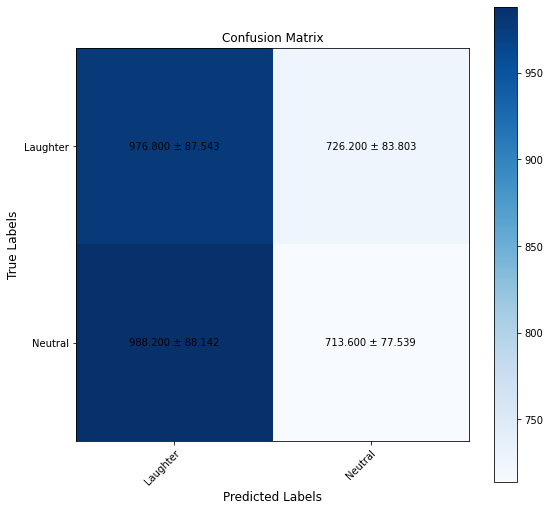

In [ ]:
mean_confusions = np.mean(np.array(conf_matrices), axis = 0)
std_confusions = np.std(np.array(conf_matrices), axis = 0)

label_names = ["Laughter", "Neutral"]

fig, ax = plt.subplots(figsize = (8, 8))
im = ax.imshow(mean_confusions, cmap = "Blues")

# We want to show all ticks...
ax.set_xticks(np.arange(len(label_names)))
ax.set_yticks(np.arange(len(label_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.xlabel("Predicted Labels", fontsize = 'large')
plt.ylabel("True Labels", fontsize = 'large')
# Loop over data dimensions and create text annotations.
for i in range(len(label_names)):
    for j in range(len(label_names)):
        text = ax.text(j, i, f'{mean_confusions[i, j]:.3f} ± {std_confusions[i, j]:.3f}',
                       ha="center", va="center", color="black")

ax.set_title("Confusion Matrix")
fig.tight_layout()
plt.colorbar(im)
plt.show()